In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, Kernel, Sum, WhiteKernel
import numpy as np
import matplotlib.pyplot as plt


ALPHA,BETA = 1,0.5
NOISE = 0.1

In [3]:
# Definition of exponential-decay kernel for local GPs

class ExponentialDecayNoiseKernel(Kernel):
    def __init__(self, alpha=1.0,beta=0.5,noise=0.1):
        self.beta=beta
        self.alpha=alpha
        self.noise = noise
    def __call__(self, X, Y=None,eval_gradient=False):
        if Y is None:
            Y = X
        # if eval_gradient:
        #     return (self.beta**self.alpha)/((X.flatten()[:,None]+Y.flatten()[None,:])+self.beta)**self.alpha,np.identity(X.shape[0])
        return ((self.beta**self.alpha)/((X.flatten()[None,:]+Y.flatten()[:,None])+self.beta)**self.alpha + self.noise*np.where(X.flatten()[None,:]-Y.flatten()[:,None] == 0, 1, 0)).T
    def diag(self, X):
        return np.diag(self(X))
    def is_stationary(self):
        return False

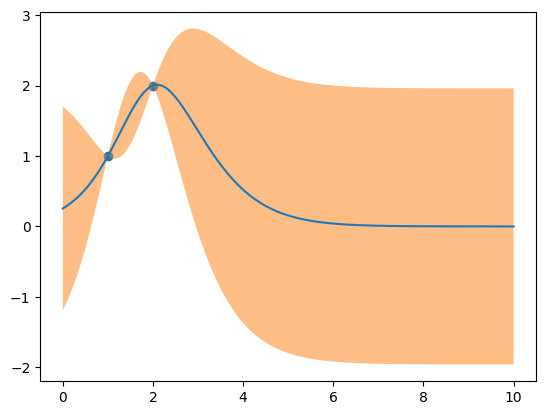

In [4]:
x_old=np.array([[1],[2]])
y_old=np.array([1,2])

global_GP= GaussianProcessRegressor(kernel=Matern(nu=2.5),n_restarts_optimizer=10)
global_GP.fit(x_old,y_old)

linspace = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
mean_prediction, std_prediction = global_GP.predict(linspace, return_std=True)
plt.scatter(x_old, y_old, label="Observations")
plt.plot(linspace, mean_prediction, label="Mean prediction")
plt.fill_between(
    linspace.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5)



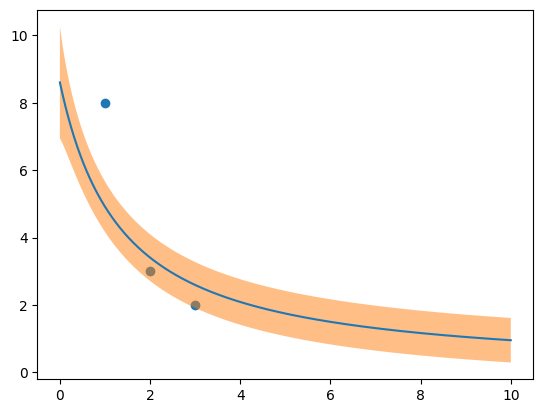

In [5]:

local_GPs={}
exp_data={}
# New datapoint
x_new=np.array([2,1])

# Experimental data at different fidelities on the new datapoint
exp_data[tuple(x_new)]=(np.array([[1],[2],[3]]),np.array([[8],[3],[2]]))

# Create GP for the learning curve of this new datapoint
local_GPs[tuple(x_new)]=GaussianProcessRegressor(kernel=ExponentialDecayNoiseKernel(ALPHA,BETA,NOISE))
local_GPs[tuple(x_new)].fit(exp_data[tuple(x_new)][0],exp_data[tuple(x_new)][1])
local_GPs[tuple(x_new)].predict(np.array([[4],[2],[3]]),return_std=True)
linspace = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
mean_prediction, std_prediction = local_GPs[tuple(x_new)].predict(linspace, return_std=True)

# plt.plot(linspace, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(exp_data[tuple(x_new)][0].flatten(), exp_data[tuple(x_new)][1], label="Observations")
plt.plot(linspace, mean_prediction, label="Mean prediction")
plt.fill_between(
    linspace.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5)